# Paris Airbnb Price
How much should I rent my flat per night?

In this project, we will use several Machine Learning models for predicting the night price of an appartment posted on Airbnb, depending on multiple variables.
The dataset is available at http://insideairbnb.com/get-the-data.html under a Creative Commons CC0 1.0 Universal (CC0 1.0) "Public Domain Dedication" license.

Before starting our work, we should check that the two following components used for Deep Learning are installed when we are running this notebook for the first time on a server, and then reset the session.

In [ ]:
!pip3 install keras
!pip install Tensorboard

## 1. Data Preprocessing
In this first part, we will explorate the data from Inside Airbnb.

The goals are to:
- Import the dataset
- Select and clean the more relevant features
- Create variables ready to be exploited by our Machine Learning models 

### 1.1 Import the dataset within the Python kernel
If the data file is not uncompressed yet, we have to uncompress it. The code below should not be run if the data has already been uncompressed. Furthermore, it supposes that the listing.csv.gz file from http://insideairbnb.com/get-the-data.html (Paris, France) is available on the 'data' folder.

In [ ]:
import gzip
import shutil
with gzip.open('data/listing.csv.gz', 'rb') as f_in:
    with open('data/listing.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Now we can import the dataset directly from the .csv file and have a quick look at it.

In [1]:
import pandas as pd
dataset = pd.read_csv('data/listings.csv', low_memory=False)
print(dataset.columns)
print(dataset.shape)

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

## 1.2 Select and clean the more relevant features

We can see that there are 96 different variables.

We will keep only the relevant ones, for solving our problem: predicting the price per night of an Airbnb flat in Paris, France. This price per night will be composed of both the price and the cleaning fee, values which we will place in the last columns of the dataset.

*I selected these variables during continuous improvement of the machine learning models for their respective relevance, and the success of the models.*
For example:
- Some of these are directly related (neighbourhood and zipcode directly depends of latitude and longitude / global review score depends on the other review scores)
- Square feet field is rarely fullfilled
- Prices are treated as strings because they contain the '$' character.
- When there is no review, the other review variables are considered 'Nan'.
- Sometimes, the other review variables are 'NaN' even though there are reviews.

In [2]:
import numpy as np
# Keeping only the relevant variables
dataset = dataset[['host_is_superhost', 'property_type','room_type','bed_type','latitude','longitude',
                   'accommodates','bathrooms','bedrooms','number_of_reviews','review_scores_accuracy',
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                   'review_scores_location','review_scores_value','price','cleaning_fee']]
# We drop all the examples which do not contain a price (our dependent variable)
dataset = dataset.dropna(subset=['price'])
# Making the prices and cleaning fees readable(they currently include the '$' sign)
# Adding the prices and cleaning fees to keep a single dependent variable
dataset['price'] = dataset['price'].replace('[\$,]', '', regex=True).astype(float) + dataset['cleaning_fee'].replace('[\$,]', '', regex=True).fillna(0).astype(float)
dataset = dataset.drop(columns=['cleaning_fee'])

# Finally, having a look at the dataset
dataset.iloc[:5,:]

,host_is_superhost,property_type,room_type,bed_type,latitude,longitude,accommodates,bathrooms,bedrooms,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,f,Loft,Entire home/apt,Real Bed,48.869933,2.362511,4,2.0,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,165.0
1,f,Apartment,Entire home/apt,Real Bed,48.833494,2.318518,2,1.0,1.0,7,10.0,10.0,10.0,10.0,10.0,10.0,125.0
2,f,Apartment,Entire home/apt,Pull-out Sofa,48.851001,2.358690,2,1.0,0.0,148,9.0,9.0,10.0,10.0,10.0,10.0,151.0
3,t,Apartment,Entire home/apt,Real Bed,48.857576,2.352751,4,1.0,2.0,231,10.0,9.0,10.0,10.0,10.0,9.0,165.0
4,f,Apartment,Entire home/apt,Real Bed,48.874642,2.343411,2,1.0,2.0,6,10.0,10.0,10.0,10.0,10.0,10.0,159.0


## 1.3 Creating exploitable variables

We will now divide the dataset between the independent variables and the dependent variable.

In order to do so, we will apply different treatments to the categorical and numerical variables, and will then gather these within X and y variables. We will nevertheless keep the numerical and categorical versions of X, so we can use these in algorithms depending on their qualities.

Once the preprocessing is completed, we will split the dataset between training and test datasets. Since the dataset is not big (less than 60.000 rows) and since we do not consider delivering a production version of the algorithm, we will not create a cross-validation set.

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Replacing "NaN" values of numerical variables
X_numerical = dataset.values[:,4:-2]
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_numerical)
X_numerical = imputer.transform(X_numerical)

# Encoding the categorical data
X_categorical = dataset[['host_is_superhost', 'property_type','room_type','bed_type']].astype('str').apply(LabelEncoder().fit_transform).astype('int64')
onehotencoder = OneHotEncoder()
X_categorical = onehotencoder.fit_transform(X_categorical).toarray()

# Merging back numerical and categorical data
X = np.append(X_categorical,X_numerical, axis=1)
y = dataset.values[:,-1:]

# Finally, we can randomly split the examples between training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_numerical, y, test_size = 0.2)
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_categorical, y, test_size = 0.2)

# 2 Machine Learning Models
Now that our data is ready to be properly used, we will create different machine learning models which will try to answer the problem:

*Predict the price per night of an Airbnb flat in Paris.*

In order to evaluate and compare the various models, we will use the **Root-Mean-Square-Error function**.

## 2.1 Linear Regression

We will start by building a classic linear regression model. We will run it only on the numerical features, since its performance is greatly improved this way.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

#The linear regression function which we will use and evaluate
def linear_regression(X_train, y_train, X_test, y_test):
    # Fitting Simple Linear Regression to the Training set
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    train_rmse = sqrt(mean_squared_error(regressor.predict(X_train),y_train))
    test_rmse = sqrt(mean_squared_error(regressor.predict(X_test),y_test))
    return train_rmse, test_rmse

Let's train and evaluate the model on different amount of data, so we can see its progress.

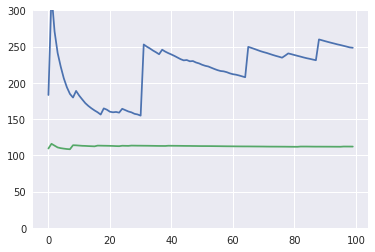

In [10]:
import matplotlib.pyplot as plt

lr_eval = pd.DataFrame(0, index=range(100), columns=['train rmse', 'test rmse']).astype(float)
for i in range(100):
  subset_size = int(round(((i+1)*X_num_train.shape[0]/100)))
  [lr_eval.values[i,0],lr_eval.values[i,1]] = linear_regression(X_num_train[:subset_size,:],y_num_train[:subset_size], X_num_test, y_num_test)
  
plt.gca().set_ylim([0,300])
plt.plot(lr_eval['train rmse'], label='Training RMSE')
plt.plot(lr_eval['test rmse'], label='Test RMSE')
plt.show()

## 2.2 Polynomial Regression

In [11]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(X_train,y_train,X_test,y_test, polynomial_degree):
  polynomialFeatures = PolynomialFeatures(degree = polynomial_degree)
  X_train_poly = polynomialFeatures.fit_transform(X_train)
  polynomialFeatures.fit(X_train_poly, y_train)
  polynomial_regressor = LinearRegression()
  polynomial_regressor.fit(X_train_poly, y_train)
  train_rmse = sqrt(mean_squared_error(polynomial_regressor.predict(X_train_poly),y_train))
  test_rmse = sqrt(mean_squared_error(polynomial_regressor.predict(polynomialFeatures.fit_transform(X_test)),y_test))
  return train_rmse,test_rmse

Polynomial Regression n°1/10...
Polynomial Regression n°2/10...
Polynomial Regression n°3/10...
Polynomial Regression n°4/10...
Polynomial Regression n°5/10...
Polynomial Regression n°6/10...
Polynomial Regression n°7/10...
Polynomial Regression n°8/10...
Polynomial Regression n°9/10...
Polynomial Regression n°10/10...


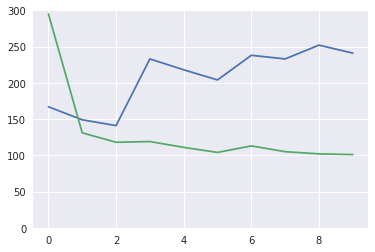

In [14]:
pl_num_eval = pd.DataFrame(0, index=range(10), columns=['train rmse', 'test rmse'])
for i in range(10):
  print('Polynomial Regression n°{}/10...'.format(i+1))
  subset_size = int(round(((i+1)*X_num_train.shape[0]/10)))
  [pl_num_eval.values[i,0],pl_num_eval.values[i,1]] = polynomial_regression(X_num_train[:subset_size,:],y_num_train[:subset_size], X_num_test[:subset_size,:], y_num_test[:subset_size], polynomial_degree = 3)
  
plt.gca().set_ylim([0,300])
plt.plot(pl_num_eval['train rmse'], label='Training RMSE')
plt.plot(pl_num_eval['test rmse'], label='Test RMSE')
plt.show()

## 2.3 Random Forest Regression

In [15]:
from sklearn.ensemble import RandomForestRegressor

def rf_regression(X_train,y_train,X_test,y_test,estimators):
  rf_regressor = RandomForestRegressor(n_estimators = estimators)
  rf_regressor.fit(X_train, y_train)
  rf_train_rmse = sqrt(mean_squared_error(rf_regressor.predict(X_train),y_train))
  rf_test_rmse = sqrt(mean_squared_error(rf_regressor.predict(X_test),y_test))
  return rf_train_rmse, rf_test_rmse

Random Forest Regression n°1/10...


/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest Regression n°2/10...
Random Forest Regression n°3/10...
Random Forest Regression n°4/10...
Random Forest Regression n°5/10...
Random Forest Regression n°6/10...
Random Forest Regression n°7/10...
Random Forest Regression n°8/10...
Random Forest Regression n°9/10...
Random Forest Regression n°10/10...


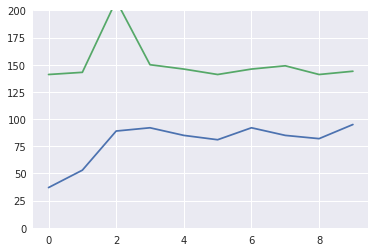

In [16]:
rf_eval = pd.DataFrame(0, index=range(10), columns=['train rmse', 'test rmse'])
for i in range(10):
  print('Random Forest Regression n°{}/10...'.format(i+1))
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [rf_eval.values[i,0],rf_eval.values[i,1]] = rf_regression(X_train[:subset_size,:],y_train[:subset_size],
                                                                    X_test, y_test, estimators = 40)
plt.gca().set_ylim([0,200])
plt.plot(rf_eval['train rmse'], label='Training RMSE')
plt.plot(rf_eval['test rmse'], label='Test RMSE')
plt.show()

## 2.4 Support Vector Regression

In [18]:
from sklearn.svm import SVR

def sv_regression(X_train,y_train,X_test,y_test):
  sv_regressor = SVR(kernel = 'rbf')
  sv_regressor.fit(X_train, y_train)
  sv_train_rmse = sqrt(mean_squared_error(sv_regressor.predict(X_train),y_train))
  sv_test_rmse = sqrt(mean_squared_error(sv_regressor.predict(X_test),y_test))
  return sv_train_rmse, sv_test_rmse

In [ ]:
sv_eval = pd.DataFrame(0, index=range(5), columns=['train rmse', 'test rmse'])
for i in range(5):
  print('Support Vector Regression n°{}/5...'.format(i+1))
  subset_size = int(round(((i+1)*X_train.shape[0]/5)))
  [sv_eval.values[i,0],sv_eval.values[i,1]] = sv_regression(X_train[:subset_size,:],y_train[:subset_size], X_test, y_test)
  
plt.gca().set_ylim([0,200])
plt.plot(sv_eval['train rmse'], label='Training RMSE')
plt.plot(sv_eval['test rmse'], label='Test RMSE')
plt.show()

## 2.5 Deep Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from time import time
from keras.callbacks import TensorBoard
from google.datalab.ml import TensorBoard as tb # if running from a Google Cloud Platform Datalab

regressor = Sequential()
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 46, units = 28))
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 28, units = 12))
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 12, units = 6))
regressor.add(Dense(kernel_initializer = 'normal', input_dim = 6, units = 1))
# Compiling the ANN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
regressor.fit(X_train, y_train, batch_size = 100, epochs = 50, callbacks=[tensorboard])
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
dnn_training_rmse = sqrt(mean_squared_error(y_train_pred, y_train))
dnn_test_rmse = sqrt(mean_squared_error(y_pred,y_test))
print(dnn_training_rmse, dnn_test_rmse)

In [ ]:
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
dnn_training_rmse = sqrt(mean_squared_error(y_train_pred, y_train))
dnn_test_rmse = sqrt(mean_squared_error(y_pred,y_test))
print(dnn_training_rmse, dnn_test_rmse)

In [ ]:
tb.start('./logs') # Only start it if it is not start yet